# Data Modeling Notebook (prior feature creation)

In the last notebook it became clear, that there is relationship between the market price and the residual load, which is the portion of consumed energy not generated by renewable sources. Especially brown and black coal are connected to the price

### Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.models import Model
from keras.models import load_model, save_model
from keras.layers import Dense, LSTM, Input, Dropout
from keras.losses import MeanSquaredError


In [2]:
sns.set_style(style='darkgrid')

### Data Loading

In [3]:
# import the dataframes
df_RConE = pd.read_pickle('../Data Cleansed/Real_consumed_energy.pkl')
df_MP = pd.read_pickle('../Data Cleansed/Market_price.pkl')
# set Timestamp as index and resample Marketprices to 15 minutes.
df_RConE.set_index('Timestamp', drop=True, inplace=True)
df_MP.set_index('Timestamp', drop=True, inplace=True)

In [4]:
df_Total_RConE = df_RConE
df_Total_RConE.rename(columns={'Total (Grid Load) [MWh]':'Total', 'Residuallast [MWh]':'Residual Load', 'Pumpspeicher [MWh]':'Pumped Storage'}, inplace=True)
df_Total_RConE['Renewables'] = df_Total_RConE['Total'] - df_Total_RConE['Residual Load'] - df_Total_RConE['Pumped Storage']

df_Total_RConE['year'] = df_Total_RConE.index
df_Total_RConE['month'] = df_Total_RConE['year'].dt.month
df_Total_RConE['day'] = df_Total_RConE['year'].dt.day
df_Total_RConE['day_of_year'] = df_Total_RConE['year'].dt.dayofyear
df_Total_RConE['year'] = df_Total_RConE['year'].dt.year

In [5]:
# no need to consider the market prices outside of Germany
MP_DE = df_MP[['Germany/Luxemburg [€/MWh]']]
MP_DE.rename(columns={'Germany/Luxemburg [€/MWh]': 'DE'}, inplace=True)

#resample MP_DE
MP_DE = MP_DE.resample('15 Min').ffill() # fills the NAN with the last known value

C:\Users\sager\AppData\Local\Temp\ipykernel_32168\4264555959.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MP_DE.rename(columns={'Germany/Luxemburg [€/MWh]': 'DE'}, inplace=True)


In [6]:
# del unncessary Dataframes to conserve memory
del df_MP
del df_RConE

Correlations between market price and Consumed Energy

In [7]:
MP_RCON = MP_DE.join(df_Total_RConE, how='inner', validate='one_to_one') # outer join on index aka Timestamp

In [8]:
del df_Total_RConE

In [9]:
MP_RCON.drop(columns=['year', 'month', 'day', 'day_of_year', 'Renewables', 'Pumped Storage', 'Total'], inplace=True)

### Preprocessing the data
1. Scale the data
2. Split the data into training and validation sets

In [10]:
Data_max_abs = MP_RCON.abs().max()

In [11]:
Data_Scaled = MP_RCON / Data_max_abs

In [12]:
print('Market prices max:', Data_Scaled['DE'].max())
print('Market prices min:', Data_Scaled['DE'].min())
print('\n')
print('Residual load max:', Data_Scaled['Residual Load'].max())
print('Residual load min:', Data_Scaled['Residual Load'].min())

Market prices max: 1.0
Market prices min: -0.574052812858783


Residual load max: 1.0
Residual load min: -0.08652674908642874


We have 105105 rows, most of them are 15 minutes apart. 
So for an hour we have 4 rows, for a day 96 row, for a week 672 rows. Days and weeks would be great batch sizes for the LSTM. 
For a stateful LSTM I need to make sure, that there is no left over in the training set (modulo = 0)

In [13]:
Data_Scaled.shape

(105105, 2)

In [14]:
# I define a function to find the right size for the train and test data.
# The right size is defined by a modulo of 0.
def get_train_length(data, window, test_percent):
    length = len(data)
    length_values=[]
    split_values=[]
    for i in range(length, int(length * (1-test_percent)), -1):
        if i % window == 0:
            length_values.append(i)
            split_values.append(i/length)
    #print (list(zip(length_values, split_values)))
    return list(zip(length_values, split_values))

**Note:** The *Keras timestep* means basically the window aka sample length of each sample batch. 

In [15]:
window = 96 # 4 samples * 24 hours = 96,

In [16]:
get_train_length(Data_Scaled, window, 0.15)

[(105024, 0.999229342086485),
 (104928, 0.9983159697445412),
 (104832, 0.9974025974025974),
 (104736, 0.9964892250606536),
 (104640, 0.9955758527187099),
 (104544, 0.9946624803767661),
 (104448, 0.9937491080348223),
 (104352, 0.9928357356928785),
 (104256, 0.9919223633509348),
 (104160, 0.991008991008991),
 (104064, 0.9900956186670472),
 (103968, 0.9891822463251034),
 (103872, 0.9882688739831597),
 (103776, 0.9873555016412159),
 (103680, 0.9864421292992721),
 (103584, 0.9855287569573283),
 (103488, 0.9846153846153847),
 (103392, 0.9837020122734409),
 (103296, 0.9827886399314971),
 (103200, 0.9818752675895533),
 (103104, 0.9809618952476096),
 (103008, 0.9800485229056658),
 (102912, 0.979135150563722),
 (102816, 0.9782217782217782),
 (102720, 0.9773084058798345),
 (102624, 0.9763950335378907),
 (102528, 0.9754816611959469),
 (102432, 0.9745682888540032),
 (102336, 0.9736549165120594),
 (102240, 0.9727415441701156),
 (102144, 0.9718281718281718),
 (102048, 0.970914799486228),
 (101952, 0.

In [17]:
Data_Scaled_train = Data_Scaled.iloc[0:89376, :].values
Data_Scaled_val = Data_Scaled.iloc[89376:, :].values

In [18]:
print('Shape of Data_Scaled_train', Data_Scaled_train.shape, '\nShape of Data_Scaled_val', Data_Scaled_val.shape)

Shape of Data_Scaled_train (89376, 2) 
Shape of Data_Scaled_val (15729, 2)


Time to split the data into Y and X

In [19]:
def createXY(dataset, n_past): #n_past is the number of past steps we want to look at aka Timesteps aka window
    dataX = []
    dataY = []

    for i in range(n_past, len(dataset)):
        dataX.append(dataset[i - n_past:i, 0:dataset.shape[1]]) # rem. both columns 'DE' and 'Residual Load' are included, as the future value of 'DE' als dependendent on its past values
        dataY.append(dataset[i, 0])
    return np.array(dataX), np.array(dataY)

In [20]:
X_train, y_train = createXY(Data_Scaled_train, window)
X_val, y_val = createXY(Data_Scaled_val, window)

In [21]:
#Check shape
print('Shape of X_train', X_train.shape, '\nShape of y_train', y_train.shape, '\nShape of X_val', X_val.shape, '\nShape of y_val', y_val.shape)

Shape of X_train (89280, 96, 2) 
Shape of y_train (89280,) 
Shape of X_val (15633, 96, 2) 
Shape of y_val (15633,)


In [22]:
X_val.shape[0]%(2*window)

81

So, the code says, I have 81 rows left, probably in X_val and Y_val.
If so, then I will need to drop them.

In [23]:
X_val_altered = X_val[:-81]
y_val_altered = y_val[:-81]

In [24]:
X_val_altered.shape[0]%(2*window)

0

In [25]:
X_val_altered.shape

(15552, 96, 2)

### Build the model

In [26]:
# LSTM stateful model with MSE loss function

#input
inputs = Input(shape=(X_train.shape[1], X_train.shape[2]), batch_size=2*window)

# LSTM layer; recurrent_activation='sigmoid' is default setting
lstm1 = LSTM(12, 
             activation='tanh',
             recurrent_activation='sigmoid', 
             return_sequences=True, 
             stateful=True,
             #dropout=0.5
             )(inputs)



# LSTM layer; recurrent_activation='sigmoid' is default setting
lstm2 = LSTM(12,
             activation='tanh',
             recurrent_activation='sigmoid',
             return_sequences=False,
             stateful=True) (lstm1)

#output
output = Dense(1, activation='tanh')(lstm2)

model = Model(inputs=inputs, outputs=output)
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

In [27]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(192, 96, 2)]            0         
                                                                 
 lstm (LSTM)                 (192, 96, 12)             720       
                                                                 
 lstm_1 (LSTM)               (192, 12)                 1200      
                                                                 
 dense (Dense)               (192, 1)                  13        
                                                                 
Total params: 1,933
Trainable params: 1,933
Non-trainable params: 0
_________________________________________________________________


Let's retry

In [28]:
history = model.fit(X_train, y_train, epochs=10, batch_size=2*window, validation_data=(X_val_altered, y_val_altered))

Epoch 1/10
465/465 [==============================] - 7s 12ms/step - loss: 0.0036 - accuracy: 0.0012 - val_loss: 3.3335e-04 - val_accuracy: 0.0028
Epoch 2/10
465/465 [==============================] - 5s 12ms/step - loss: 4.2596e-04 - accuracy: 0.0012 - val_loss: 2.2136e-04 - val_accuracy: 0.0028
Epoch 3/10
465/465 [==============================] - 5s 12ms/step - loss: 2.8481e-04 - accuracy: 0.0012 - val_loss: 1.8301e-04 - val_accuracy: 0.0028
Epoch 4/10
465/465 [==============================] - 5s 11ms/step - loss: 2.3453e-04 - accuracy: 0.0012 - val_loss: 1.5276e-04 - val_accuracy: 0.0028
Epoch 5/10
465/465 [==============================] - 5s 12ms/step - loss: 2.0906e-04 - accuracy: 0.0012 - val_loss: 1.3797e-04 - val_accuracy: 0.0028
Epoch 6/10
465/465 [==============================] - 5s 11ms/step - loss: 1.9182e-04 - accuracy: 0.0012 - val_loss: 1.2470e-04 - val_accuracy: 0.0028
Epoch 7/10
465/465 [==============================] - 5s 11ms/step - loss: 1.8112e-04 - accuracy: 

In [29]:
prediction = model.predict(X_val_altered, batch_size=2*window)

81/81 [==============================] - 1s 6ms/step


In [30]:
prediction.shape

(15552, 1)

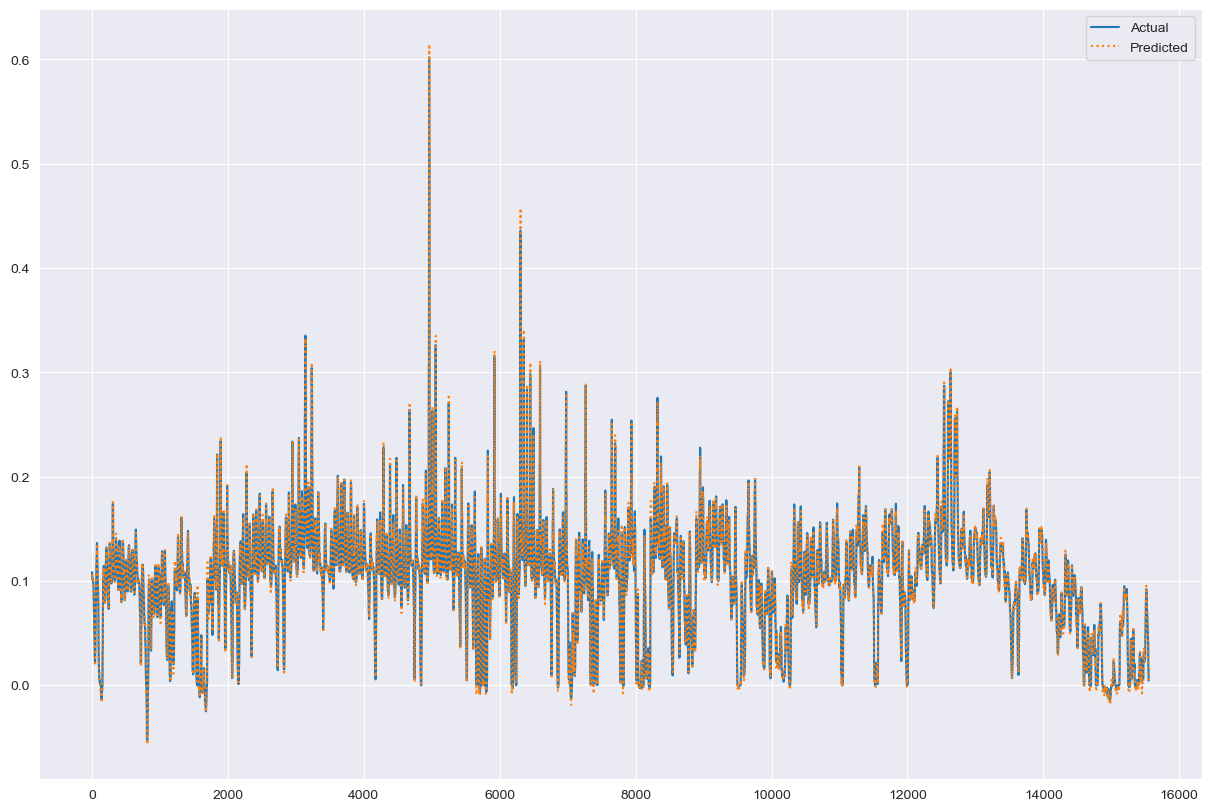

In [31]:
plt.figure(figsize=(15,10))
plt.plot(y_val_altered, label='Actual')
plt.plot(prediction, label='Predicted', linestyle='dotted')
plt.legend()
plt.show()

In [32]:
save_model(model, 'model_before.h5')

Denormalize the values

In [28]:
model = load_model('model_before.h5')

81/81 [==============================] - 1s 7ms/step


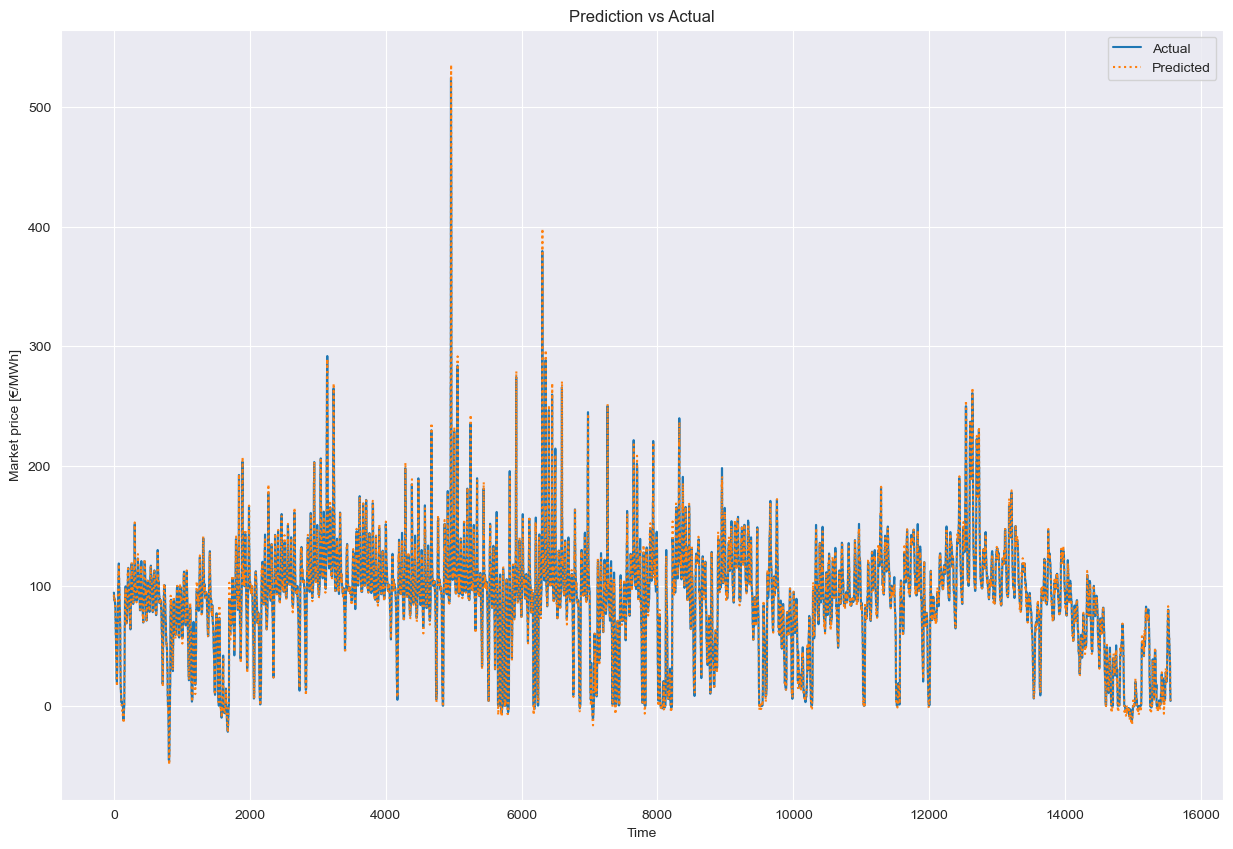

In [33]:
prediction = model.predict(X_val_altered, batch_size=2*window)
plt.figure(figsize=(15,10))
plt.plot(y_val_altered*Data_max_abs['DE'], label='Actual')
plt.plot(prediction*Data_max_abs['DE'], label='Predicted', linestyle='dotted')
plt.xlabel('Time')
plt.ylabel('Market price [€/MWh]')
plt.title('Prediction vs Actual')
plt.legend()
plt.show()

In [34]:
#let's take a closer look at the prediction

print('max value from prediction:', Data_max_abs['DE']*prediction.max())
print('max value from actual:', Data_max_abs['DE']*y_val_altered.max())
print('\n')
print('min value from prediction:', Data_max_abs['DE']*prediction.min())
print('min value from actual:', Data_max_abs['DE']*y_val_altered.min())

max value from prediction: 535.1625686883926
max value from actual: 524.27


min value from prediction: -49.2686160877347
min value from actual: -46.61


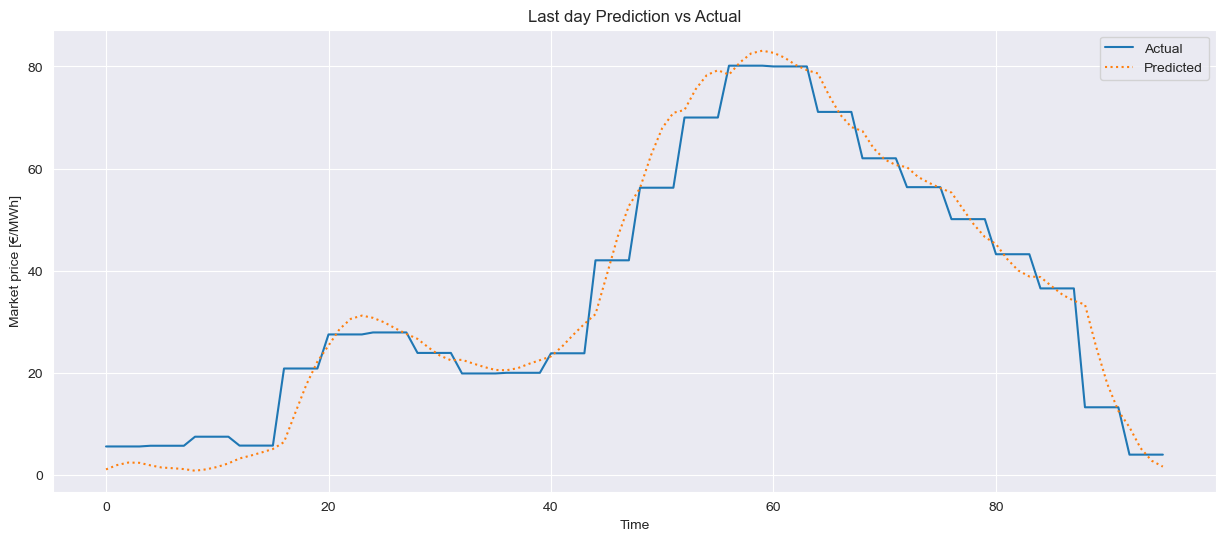

In [35]:
plt.figure(figsize=(15,6))
plt.plot(y_val_altered[-96:]*Data_max_abs['DE'], label='Actual')
plt.plot(prediction[-96:]*Data_max_abs['DE'], label='Predicted', linestyle='dotted')
plt.xlabel('Time')
plt.ylabel('Market price [€/MWh]')
plt.title('Last day Prediction vs Actual')

plt.legend()
plt.show()

In [36]:
print('location of max value from prediction:', prediction.argmax())
print('location of max value from actual:', y_val_altered.argmax())
print('\n')
print('location of min value from prediction:', prediction.argmin())
print('location of min value from actual:', y_val_altered.argmin())

location of max value from prediction: 4964
location of max value from actual: 4960


location of min value from prediction: 815
location of min value from actual: 812


In [37]:
# want to see the entire day, where the extreme values are.
print(4960/96)
print(812/96)

51.666666666666664
8.458333333333334


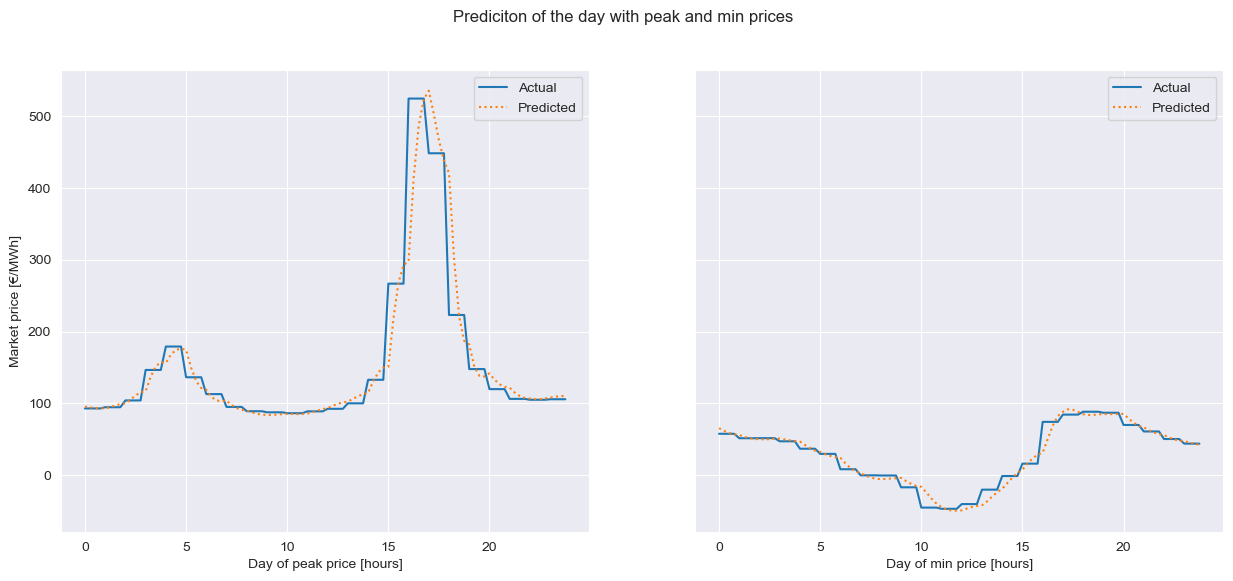

In [38]:
fig, (ax1, ax2)= plt.subplots(1,2, figsize=(15,6), sharey=True)
fig.suptitle('Prediciton of the day with peak and min prices')

ax1.plot(y_val_altered[51*96:52*96]*Data_max_abs['DE'], label='Actual')
ax1.plot(prediction[51*96:52*96]*Data_max_abs['DE'], label='Predicted', linestyle='dotted')
ax1.set_xlabel('Day of peak price [hours]')
ax1.set_ylabel('Market price [€/MWh]')
ax1.xaxis.set_major_formatter(lambda x, pos:"%.0f" % (x/4))
ax1.legend()

ax2.plot(y_val_altered[8*96:9*96]*Data_max_abs['DE'], label='Actual')
ax2.plot(prediction[8*96:9*96]*Data_max_abs['DE'], label='Predicted', linestyle='dotted')
ax2.set_xlabel('Day of min price [hours]')
ax2.xaxis.set_major_formatter(lambda x, pos:"%.0f" % (x/4))
ax2.legend()




plt.show()

### Test with completly unknown data

In [39]:
df_test_data = pd.read_pickle('../Data Cleansed/Test_Market_price_Real_consumed_energy.pkl')

This data contains the market prices and consumption data for the period 1st/Jan/2024 till midnight 4th/Mar/2024

In [40]:
print(df_test_data.head())
print(df_test_data.tail())

                         DE  Residual Load
Timestamp                                 
2024-01-01 01:00:00  0.1000         855.25
2024-01-01 01:15:00  0.0775         733.75
2024-01-01 01:30:00  0.0550         712.25
2024-01-01 01:45:00  0.0325         743.75
2024-01-01 02:00:00  0.0100         618.00
                        DE  Residual Load
Timestamp                                
2024-03-03 23:00:00  72.18        7913.00
2024-03-03 23:15:00  72.24        7980.75
2024-03-03 23:30:00  72.30        7949.75
2024-03-03 23:45:00  72.36        7933.75
2024-03-04 00:00:00  72.42        7883.50


In [41]:
# for scaling I am reusing the scale I have already generated above
test_data_scaled = df_test_data/Data_max_abs
print('Max value','\n',test_data_scaled.max())
print('Min value', '\n',test_data_scaled.min())

Max value 
 DE               0.172319
Residual Load    0.911821
dtype: float64
Min value 
 DE              -0.005557
Residual Load    0.003346
dtype: float64


In [42]:
print('Shape of Test Data Scaled', test_data_scaled.shape)

Shape of Test Data Scaled (6045, 2)


In [43]:
test_data_scaled.shape[0]/(2*window)

31.484375

In [44]:
test_data_scaled.shape[0]%(2*window)

93

In [45]:
test_dataset = test_data_scaled[0:31*2*window].values

In [46]:
X_test, y_test = createXY(test_dataset, 2*window)

30/30 [==============================] - 1s 14ms/step


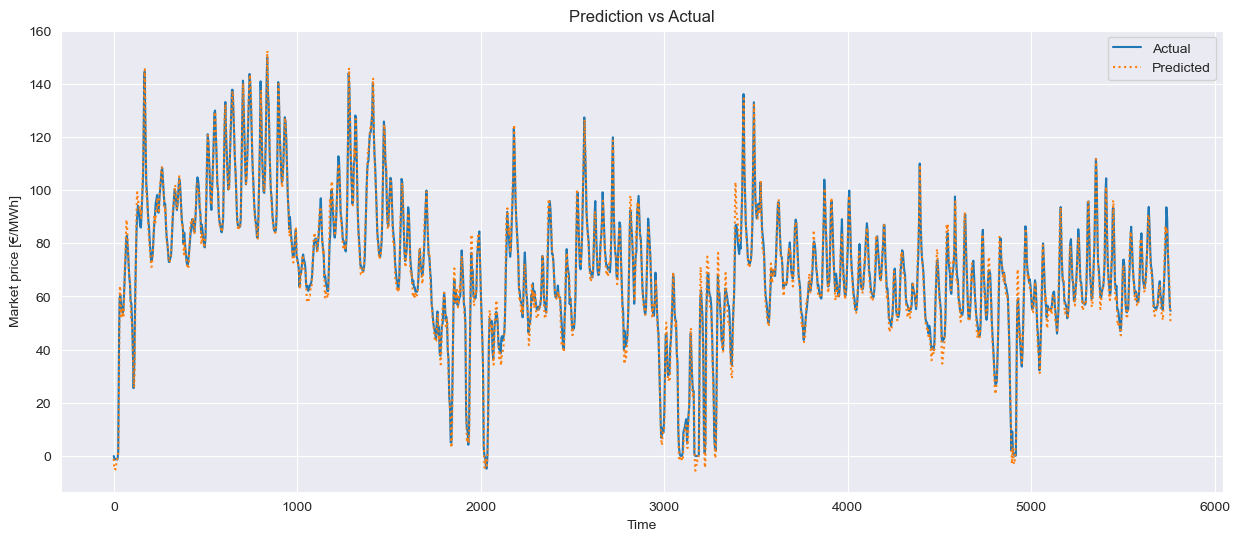

In [47]:
prediction_on_test_data = model.predict(X_test, batch_size=2*window)
plt.figure(figsize=(15,6))
plt.plot(y_test*Data_max_abs['DE'], label='Actual')
plt.plot(prediction_on_test_data*Data_max_abs['DE'], label='Predicted', linestyle='dotted')
plt.xlabel('Time')
plt.ylabel('Market price [€/MWh]')
plt.title('Prediction vs Actual')
plt.legend()
plt.show()

In [53]:
from sklearn.metrics import mean_squared_error
print('\033[1;31mThe MEAN SQUARE ERROR is:\033[0m ', mean_squared_error(y_test, prediction_on_test_data))

The MEAN SQUARE ERROR is:  1.2954499029236689e-05


The MSE for the training set and validation set were 3.5360e-05 and 1.8850e-05 respectively. 
So the test data has an even better fit than the training and validation data set.

# Result

In [49]:
df_test_data['DE'][0:df_test_data.shape[0]-2*window].tail(2)

Timestamp
2024-03-01 23:45:00    67.3075
2024-03-02 00:00:00    66.3900
Name: DE, dtype: float64

In [50]:
df_prediction = pd.DataFrame(prediction_on_test_data[-2*window:]*Data_max_abs['DE'])
df_prediction['Timestamp'] = pd.date_range(start='2024-03-02 00:15:00', end='2024-03-04 00:00:00', freq='15min')
df_prediction.set_index('Timestamp', inplace=True)

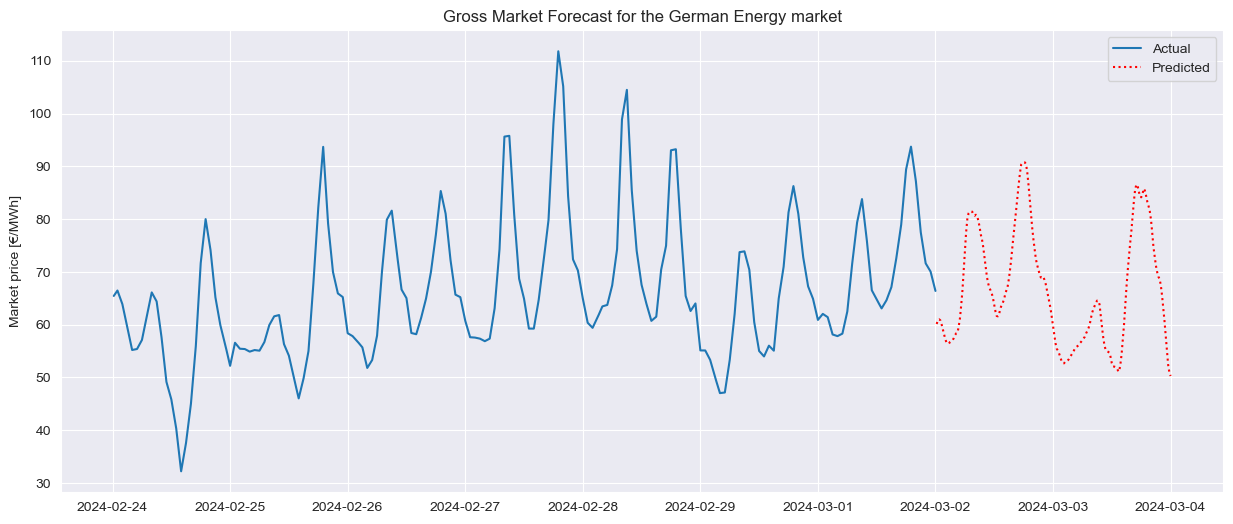

In [51]:

plt.figure(figsize=(15,6))
#plt.plot(df_test_data['DE'][df_test_data.shape[0]-2*window: df_test_data.shape[0]], color='green')
plt.plot(df_test_data['DE'][-9*window:df_test_data.shape[0]-2*window], label='Actual')
plt.plot(df_prediction, color='red', label='Predicted', linestyle='dotted')
plt.ylabel('Market price [€/MWh]')
plt.title('Gross Market Forecast for the German Energy market')
plt.legend()
plt.show()

### Conclusion

The model works surprisingly well. It is predicting the course of gross market prices two days ahead. 
The results for this model are:

|           | Training      | Validation    | Testing   |
|-----------|---------------|---------------|-----------|
|This Model | 1.6511e-04    | 1.0568e-04    | 1.2955e-05|

### Next Step

Feature Creation for improved performance of the model